In [1]:
!nvidia-smi

Mon May  1 21:05:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.29                 Driver Version: 531.29       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8                3W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Code for running the model and getting emotion from webcam

In [ ]:
import cv2
import numpy as np
from keras.models import model_from_json


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

# start the webcam feed
cap = cv2.VideoCapture(0)

# pass here your video path
# you may download one from here : https://www.pexels.com/video/three-girls-laughing-5273028/
# cap = cv2.VideoCapture("C:\\JustDoIt\\ML\\Sample_videos\\emotion_sample6.mp4")

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Loaded model from disk


In [3]:
!pip install numpy

# Preparing the data

In [5]:
import numpy

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
# initialize data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
# Preprocessing all test data
train_generator = train_data_gen.flow_from_directory(
    'train',
    target_size = (48,48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = 'categorical')

Found 28709 images belonging to 7 classes.


In [4]:
# Preprocess all training images
validation_generator = validation_data_gen.flow_from_directory(
    'test',
    target_size = (48,48), # setting input shape to 48,48
    batch_size = 64, 
    color_mode = "grayscale", # setting color as 1 (grayscale)
    class_mode = 'categorical')

Found 7178 images belonging to 7 classes.


# Model 1

In [ ]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3,3), activation= 'relu', input_shape=(48,48,1))) #input_shape: 48,48 & grayscale
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25)) # to avoid overfitting

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25)) #to avoid overfitting

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))
# in the final dense layer, the 7 outputs are the 7 categories, outputted with softmax

In [11]:
emotion_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=10e-5, decay=1e-6), metrics=['accuracy'])

In [12]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [13]:
# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

C:\Users\dhruv\AppData\Local\Temp\ipykernel_17884\3198193097.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


Epoch 1/50
448/448 [==============================] - 253s 537ms/step - loss: 1.7998 - accuracy: 0.2615 - val_loss: 1.6872 - val_accuracy: 0.3467
Epoch 2/50
448/448 [==============================] - 242s 541ms/step - loss: 1.6095 - accuracy: 0.3731 - val_loss: 1.5242 - val_accuracy: 0.4145
Epoch 3/50
448/448 [==============================] - 105s 234ms/step - loss: 1.5064 - accuracy: 0.4176 - val_loss: 1.4420 - val_accuracy: 0.4474
Epoch 4/50
448/448 [==============================] - 13s 29ms/step - loss: 1.4350 - accuracy: 0.4507 - val_loss: 1.4037 - val_accuracy: 0.4646
Epoch 5/50
448/448 [==============================] - 15s 34ms/step - loss: 1.3730 - accuracy: 0.4778 - val_loss: 1.3434 - val_accuracy: 0.4854
Epoch 6/50
448/448 [==============================] - 12s 27ms/step - loss: 1.3304 - accuracy: 0.4954 - val_loss: 1.3052 - val_accuracy: 0.5045
Epoch 7/50
448/448 [==============================] - 15s 33ms/step - loss: 1.2873 - accuracy: 0.5101 - val_loss: 1.2632 - val_acc

In [66]:
loss = emotion_model_info.history['loss']
val_loss = emotion_model_info.history['val_loss']
acc = emotion_model_info.history['accuracy']
val_acc = emotion_model_info.history['val_accuracy']

# Plot the training and validation loss curves
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'emotion_model_info' is not defined

In [ ]:
# saving the model
model_json = emotion_model.to_json()

with open("local_emotion_model.json","w") as json_file:
  json_file.write(model_json)


# save trained model weights in .h5 file
emotion_model.save_weights('local_emotion_model.h5')

# Model 2

In [42]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

In [43]:
# shared parameters
params = {'kernel_size': 3, 'activation':'relu', 'padding':'same'}

# function for convolutional block
def conv_block(x, filters, pool):
    x = Conv2D(filters, **params)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, **params)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (pool,pool))(x)
    x = Dropout(0.25)(x)
    
    return x 

In [57]:
# Creating a model using the conv_block
visible = Input(shape=(48,48,1), name= 'input')

x = conv_block(visible, 64, 2)

x = conv_block(x, 128, 2)

x = conv_block(x, 256, 2)

x = conv_block(x, 512, 2)

x = conv_block(x, 512, 2)

x = conv_block(x, 1024, 1)

x = conv_block(x, 1024, 1)


# Adding final layer
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

emoticon_model = Model(inputs=visible, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 24, 64), dtype=tf.float32, name=None), name='dropout_96/Identity:0', description="created by layer 'dropout_96'")
KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 128), dtype=tf.float32, name=None), name='dropout_97/Identity:0', description="created by layer 'dropout_97'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='dropout_98/Identity:0', description="created by layer 'dropout_98'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 512), dtype=tf.float32, name=None), name='dropout_99/Identity:0', description="created by layer 'dropout_99'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='dropout_100/Identity:0', description="created by layer 'dropout_100'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 1024), dtype=tf.float32, name=None), name='dropout_101/Identity:0', description="created by layer 'dropout_101'")
KerasTensor(ty

In [58]:
emoticon_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_216 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_153 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_217 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_154 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 24, 24, 64)       0   

_________________________________________________________________


In [59]:
emoticon_model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=2e-3, decay=1e-6), metrics=['accuracy'])

In [62]:
emoticon_model_history = emoticon_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64
        )


Epoch 1/50
448/448 [==============================] - 250s 513ms/step - loss: 2.1240 - accuracy: 0.2388 - val_loss: 1.8378 - val_accuracy: 0.2415
Epoch 2/50
448/448 [==============================] - 209s 467ms/step - loss: 1.7300 - accuracy: 0.2968 - val_loss: 1.6396 - val_accuracy: 0.3518
Epoch 3/50
448/448 [==============================] - 77s 173ms/step - loss: 1.5797 - accuracy: 0.3836 - val_loss: 1.4684 - val_accuracy: 0.4212
Epoch 4/50
448/448 [==============================] - 78s 174ms/step - loss: 1.4528 - accuracy: 0.4403 - val_loss: 1.6012 - val_accuracy: 0.4651
Epoch 5/50
448/448 [==============================] - 78s 174ms/step - loss: 1.3583 - accuracy: 0.4746 - val_loss: 1.3646 - val_accuracy: 0.5028
Epoch 6/50
448/448 [==============================] - 78s 175ms/step - loss: 1.3019 - accuracy: 0.5070 - val_loss: 1.2562 - val_accuracy: 0.5194
Epoch 7/50
448/448 [==============================] - 78s 174ms/step - loss: 1.2503 - accuracy: 0.5352 - val_loss: 1.2275 - val_

In [67]:
# The model seems to be overfitting, apply regularization and increase dropoutss and reduce model complexity.

# saving the model
model_json = emoticon_model.to_json()

with open("local_emoticon_model.json","w") as json_file:
  json_file.write(model_json)


# save trained model weights in .h5 file
emoticon_model.save_weights('local_emoticon_model.h5')

# Checking the metrics

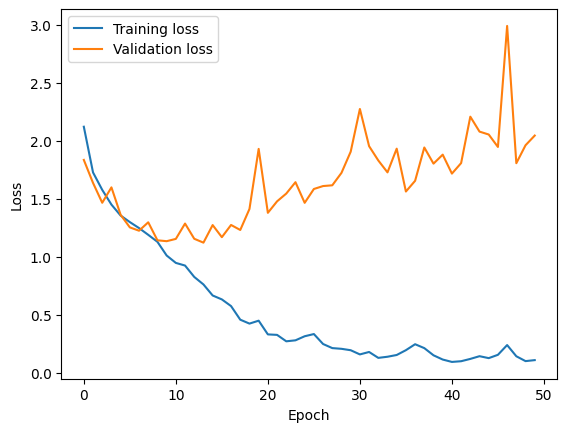

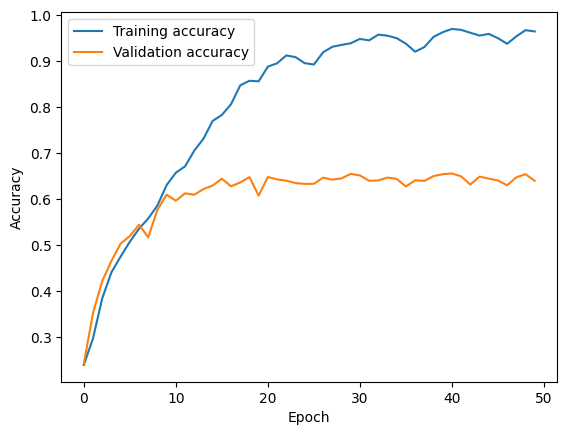

In [65]:
loss = emoticon_model_history.history['loss']
val_loss = emoticon_model_history.history['val_loss']
acc = emoticon_model_history.history['accuracy']
val_acc = emoticon_model_history.history['val_accuracy']

# Plot the training and validation loss curves
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Loaded model from disk
Found 7178 images belonging to 7 classes.


C:\Users\dhruv\AppData\Local\Temp\ipykernel_516\1061149618.py:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


-----------------------------------------------------------------
[[111  11 116 253 216 144 107]
 [ 14   0  12  32  25  19   9]
 [132  13 125 256 223 161 114]
 [208  16 236 457 381 274 202]
 [143  14 165 320 263 190 138]
 [117  10 147 340 290 198 145]
 [ 77  12 100 234 169 153  86]]


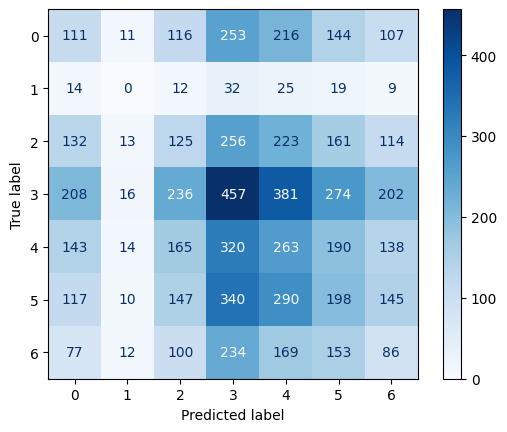

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       958
           1       0.00      0.00      0.00       111
           2       0.14      0.12      0.13      1024
           3       0.24      0.26      0.25      1774
           4       0.17      0.21      0.19      1233
           5       0.17      0.16      0.17      1247
           6       0.11      0.10      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [7]:

import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# load json and create model
json_file = open('local_emoticon_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("local_emoticon_model.h5")
print("Loaded model from disk")

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        'test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

# see predictions
# for result in predictions:
#     max_index = int(np.argmax(result))
#     print(emotion_dict[max_index])

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))

In [2]:
!pip install -U scikit-learn

     ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/8.3 MB 1.6 MB/s eta 0:00:06
      --------------------------------------- 0.2/8.3 MB 2.1 MB/s eta 0:00:04
     - -------------------------------------- 0.4/8.3 MB 2.9 MB/s eta 0:00:03
     -- ------------------------------------- 0.6/8.3 MB 3.2 MB/s eta 0:00:03
     --- ------------------------------------ 0.7/8.3 MB 3.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.0/8.3 MB 3.5 MB/s eta 0:00:03
     ----- ---------------------------------- 1.2/8.3 MB 3.7 MB/s eta 0:00:02
     ------ --------------------------------- 1.4/8.3 MB 3.8 MB/s eta 0:00:02
     ------- -------------------------------- 1.5/8.3 MB 3.6 MB/s eta 0:00:02
     -------- ------------------------------- 1.7/8.3 MB 3.7 MB/s eta 0:00:02
     --------- ------------------------------ 2.0/8.3 MB 3.8 MB/s eta 0:00:02
     ---------- ----------------------------- 2.2/8.3 MB 3.8 MB/s eta 0